## Whole Slide Imaging De-identification

In this notebook, we will explore how to handle the de-identification of Whole Slide Imaging (WSI) files, specifically focusing on SVS files.</br>
We will cover:
* Removal of auxiliary images, like macro and label images.
* Removal of Metadata.
* Main image cleaning: in this situation we don't want to remove the entire image like the case of for example macro or label images, but we want to remove only specific regions which contain PHI. We want to do this keeping the quality of the original image intact. This process involves the following steps which we will discuss in next sections,
  * Extract Tiles from SVS
  * Deidentify Tiles
  * Update the original source SVS file to mask tiles containing PHI.

Let's jump right in!

### Introduction to the SVS file format

The SVS file format (commonly used for whole slide images (WSI) in digital pathology) is based on the TIFF format and supports multi-resolution (pyramidal) image storage. It allows storing extremely large images efficiently, along with metadata and multiple resolutions for fast zooming and viewing.
SVS typically stores images in a pyramid of resolutions,
* level 0 -> full resolution.
* level 1 -> downsampled version, like 1/4 of the resolution at level 0.
* ...
* level N -> more downsampling.

Something like this(image taken from nema.org),</br>
![sample wsi](https://dicom.nema.org/dicom/dicomwsi/sup145_fromword_files/image008.gif)

At each level, images are not stored as a single monolithic unit, but as a set of _tiles_. This enables for a more efficient handling of the image by viewers.</br>
We'll see how we can exploit this characteristic to process the images in parallel and in the most efficient manner.

### Real World Example

In [1]:
secret = ""
license = ""
aws_access_key = ""
aws_secret_key = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

### Initialization of spark session

In [2]:
from sparkocr import start
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

nlp_secret = "6.1.1-xyz"

spark = start(secret=secret, use_gpu=True,
              jar_path=spark_ocr_jar_path, nlp_internal="6.1.1", nlp_version="6.1.3", nlp_secret=nlp_secret)

spark

Spark version: 3.5.0
Spark NLP version: 6.1.3
Spark NLP for Healthcare version: 6.1.1
Spark OCR version: 6.1.1



25/10/13 20:17:19 WARN Utils: Your hostname, jose-LOQ-15ARP9 resolves to a loopback address: 127.0.1.1; using 192.168.0.19 instead (on interface wlo1)
25/10/13 20:17:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/jose/spark-ocr/sparkocr/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jose/.ivy2/cache
The jars for the packages stored in: /home/jose/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp-gpu_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-770f36fb-d2d1-4277-b3af-00bcefe58fc7;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp-gpu_2.12;6.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in ce

### Removal of auxiliary images, like macro and label images, along with metadata.
First things first, before diving into the full resolution images, let's see how to remove the auxiliary images and the metadata. For this, the `svs.remove_phi()` comes handy. Let's take a look at the documentation,

In [3]:
from sparkocr.utils.svs.phi_cleaning import remove_phi
help(remove_phi)

Help on function remove_phi in module sparkocr.utils.svs.phi_cleaning:

remove_phi(input, output, tags=['ImageDescription.Filename', 'ImageDescription.Date', 'ImageDescription.Time', 'ImageDescription.User'], append_tags=[], rename=False, verbose=False)
    Remove label images, macro images, and specified metadata from SVS files.

    This function processes SVS files to remove sensitive metadata and associated images.
    By default, it removes specific metadata tags: "ImageDescription.Filename",
    "ImageDescription.Date", "ImageDescription.Time", and "ImageDescription.User".

    Parameters:
    - input (str): The file path or directory containing the SVS files to be de-identified.
    - output (str): The file path or directory where the de-identified files will be saved.
    - tags (list, optional): A list of metadata tags to remove, replacing the default tags if provided.
    - append_tags (list, optional): Additional tags to remove, added to the defaults without overriding them.

So we see from the documentation that we can remove label, and macro images along with a predefined set of metadata tags. We can also add our own custom list of tags.</br>
We have everything we need, so let's do it!,

In [4]:
# make sure input files are in this folder
input_path = './grundium/'
output_path = "./deid_grundium/"

remove_phi(input_path, output_path, verbose=True)

de-identifying ./grundium/Ocus40-sample-162.svs
cleaned: label
cleaned: macro
cleaned tag field: ImageDescription.Filename
cleaned tag field: ImageDescription.Date
cleaned tag field: ImageDescription.Time
cleaned tag field: ImageDescription.User
cleaned tag field: ImageDescription.Filename
cleaned tag field: ImageDescription.Date
cleaned tag field: ImageDescription.Time
cleaned tag field: ImageDescription.User
cleaned tag field: ImageDescription.Filename
cleaned tag field: ImageDescription.Date
cleaned tag field: ImageDescription.Time
cleaned tag field: ImageDescription.User
cleaned tag field: ImageDescription.Filename
cleaned tag field: ImageDescription.Date
cleaned tag field: ImageDescription.Time
cleaned tag field: ImageDescription.User
cleaned tag field: ImageDescription.Filename
cleaned tag field: ImageDescription.Date
cleaned tag field: ImageDescription.Time
cleaned tag field: ImageDescription.User
Copied ./grundium/Ocus40-sample-162.svs as ./deid_grundium/Ocus40-sample-162(1).sv

#### [optional] Tweaking additional parameters
You can safely skip this if you are good with the set of metadata tags that were removed.

In [ ]:
input_path = './grundium/'
output_path = "./deid_grundium/"

remove_phi(input_path, output_path, verbose=True, append_tags=['ImageDescription.ScanScope ID', 'ImageDescription.Time Zone', 'ImageDescription.ScannerType'])

### Cleaning of the main image
Here we will de-identify the main image. We start by pulling the tiles out of the SVS.

In [5]:
!ls -l ./deid_grundium

total 8779004
-rw-rw-r-- 1 jose jose  751521251 Oct  2 11:56 Ocus40-sample-157.svs
-rw-rw-r-- 1 jose jose 3668479044 Oct  2 11:56 Ocus40-sample-162.svs
-rw-rw-r-- 1 jose jose 4569684428 Oct  2 11:56 Ocus40-sample-163.svs


In [26]:
# Let's pick one file
input_path = "./deid_grundium/Ocus40-sample-157.svs"
OUTPUT_FOLDER = "./tiles_output_157/"

In [7]:
from sparkocr.utils.svs.tile_extraction import svs_to_tiles

svs_to_tiles(input_path, OUTPUT_FOLDER, level="auto", thumbnail = True)

Processing file: Ocus40-sample-157.svs


#### Text Detection

In [5]:
import matplotlib.pyplot as plt

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, display_images, to_pil_image

Here, we point to the `selected` folder which is the level at which the resolution is optimal for text detection, both in terms of accuracy and speed.

In [6]:
temp_tile_output = "./tiles_output_157/Ocus40-sample-157/selected"
image_df = spark.read.format("binaryFile").load(temp_tile_output)

At this point, `image_df` has all the tiles, from the selected level in the source SVS file. Next thing we need to do is to try to detect text and PHI in those tiles.</br>
Let's define the pipeline steps we need to accomplish this.

In [7]:
bin_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setImageType(ImageType.TYPE_BYTE_GRAY) \
    .setKeepInput(False)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setLinkThreshold(0.5) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setSizeThreshold(-1) \
    .setWidth(0) \
    .setUseGPU(True)

new_stages = [
    bin_to_image,
    text_detector
]

svs_text_detection = PipelineModel(stages=new_stages)

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB


25/10/13 20:18:23 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/13 20:18:23 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB
Download done! Loading the resource.


#### [optional] Using Synthetic Text
At this point, we are about to run text detection on the inputs tiles, but for this particualar example, there is no text contained in any tile. In order to make this example a bit more interesting, let's replace one of the 200 tiles with one for which we have added some PHI manually.

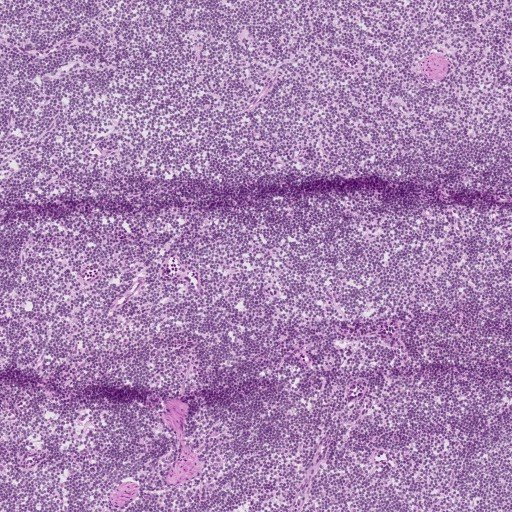

In [8]:
from PIL import Image

target_tile = "./tiles_output_157/Ocus40-sample-157/selected/Ocus40-sample-157_L3_T76.jpg"
Image.open(target_tile)

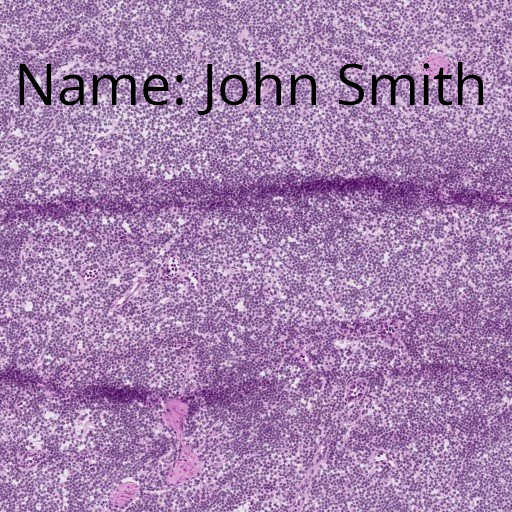

In [9]:
synth_tile = "./Ocus40-sample-157_L3_T76_synth.jpg"
Image.open(synth_tile)

In [10]:
# finally copy, and replace it
!cp $synth_tile $target_tile

IOStream.flush timed out


In [12]:
# if you used synthetic data, you need to load images again,
image_df = spark.read.format("binaryFile").load(temp_tile_output)

In [16]:
# repartition so we don't exhaust GPU resources, try lower values for smaller GPUs, or higher otherwise.
result = svs_text_detection.transform(image_df).repartition(4)

#### Inspect target images
Let's look into some of the images containing text,

2025-10-13 20:20:04.235923145 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-13 20:20:04.235951689 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-10-13 20:20:04.282706157 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-13 20:20:04.282738578 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-10-13 20:20:04.288713061 [W:onnxrun


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/deid-and-obfuscation/tiles_output_157/Ocus40-sample-157/selected/Ocus40-sample-157_L3_T76.jpg
    Resolution: 300 dpi
    Width: 512 px
    Height: 512 px
    Mode: 10
    Number of channels: 1


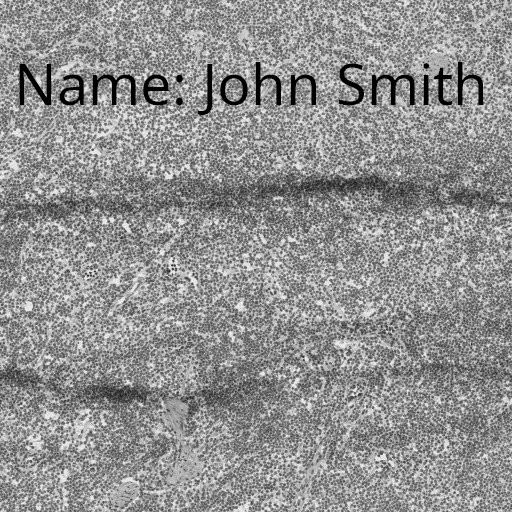


    Image #1:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/deid-and-obfuscation/tiles_output_157/Ocus40-sample-157/selected/Ocus40-sample-157_L3_T61.jpg
    Resolution: 0 dpi
    Width: 512 px
    Height: 512 px
    Mode: 10
    Number of channels: 1


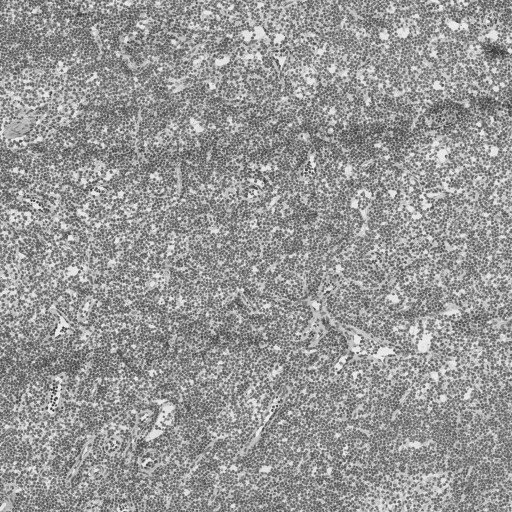

CPU times: user 39.1 ms, sys: 6.92 ms, total: 46 ms
Wall time: 7.03 s


In [17]:
%%time
from pyspark.sql.functions import size

result = result.filter(size(result["text_regions"]) > 0).cache()
display_images(result, "image_raw")

**NOTE**: Here we can see the different tiles and the text that was detected on each of them. You can filter the tiles with detected text and use it as input for deid pipeline, other tiles won't be fed into the pipeline, so that we don't waste resources analyzing them.</br>
Out of the 200 tiles present, one contains text(and was detected) and the other one is a false positive, which will be rejected by subsequent stages.

#### PHI removal per-se

In [18]:
from sparkocr.pretrained import PretrainedPipeline
deid_pipeline = PretrainedPipeline("image_deid_multi_model_context_pipeline_cpu", "en", "clinical/ocr")

image_deid_multi_model_context_pipeline_cpu download started this may take some time.


25/10/13 20:20:32 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approx size to download 4.9 GB
[ | ]

25/10/13 20:20:33 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/13 20:20:33 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


image_deid_multi_model_context_pipeline_cpu download started this may take some time.
Approximate size to download 4.9 GB
Download done! Loading the resource.
[ / ]

2025-10-13 20:20:37.531347: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.4/lib64:
2025-10-13 20:20:37.531815: I external/org_tensorflow/tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-10-13 20:20:37.874534: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-13 20:20:37.875927: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had

[ \ ]

2025-10-13 20:20:42.497071: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-13 20:20:42.501654: W external/org_tensorflow/tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-10-13 20:20:42.544956: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devi

[ — ]

2025-10-13 20:20:59.753404: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-13 20:20:59.758472: W external/org_tensorflow/tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-10-13 20:21:00.418606: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 768006144 exceeds 10% of free system memory.


[ — ]

2025-10-13 20:21:08.420933: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:630] NodeDef mentions attribute validate_shape which is not in the op definition: Op<name=AssignVariableOp; signature=resource:resource, value:dtype -> ; attr=dtype:type; is_stateful=true> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node char_repr_cnn/conv1d/kernel/Assign}}
2025-10-13 20:21:08.490975: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-13 20:21:08.495703: W external/org_tensorflow/tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/in

[ | ]

[Stage 164:>                                                        (0 + 1) / 1]

[ / ]

[ — ]

[OK!]


### Run pipeline

In [19]:
# we already have detected text, remove text detector
deid_pipeline.model.stages = deid_pipeline.model.stages[1:]

In [20]:
result_deid = deid_pipeline.transform(result)
deid_info = result_deid.select("path", "coordinates").distinct()

In [21]:
deid_info.distinct().show(5, False)

25/10/13 20:21:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/10/13 20:21:28 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
[Stage 182:==========================================>              (3 + 1) / 4]

Using CUDA


2025-10-13 20:21:36.549815810 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 81 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2025-10-13 20:21:36.569157639 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-13 20:21:36.569170493 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


Using CUDA


2025-10-13 20:21:38.569054446 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 45 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2025-10-13 20:21:38.575980688 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-13 20:21:38.575990988 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
25/10/13 20:21:39 WARN PositionFinder: Empty or null entity value is not allowed.
25/10/13 20:21:39 ERROR ImageDrawRegions: Invalid or empty `coordinates`: Ensure it is non-empty and contains 

+----------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------+
|path                                                                                                                                    |coordinates                                                           |
+----------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------+
|file:/home/jose/spark-ocr/workshop/jupyter/deid-and-obfuscation/tiles_output_157/Ocus40-sample-157/selected/Ocus40-sample-157_L3_T76.jpg|[{0, 0, 188.76651, 58.981586, 301.29327, 56.8552, 0.0, 0, 0.0, false}]|
|file:/home/jose/spark-ocr/workshop/jupyter/deid-and-obfuscation/tiles_output_157/Ocus40-sample-157/selected/Ocus40-sample-157_L3_T61.jpg|[]                    

25/10/13 20:21:39 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

#### [optional] Cache regions using parquet
We can cache the regions in disk, to avoid potential re-computation and to be able to recover in case of failure.

In [ ]:
deid_info.repartition(10).write.format("parquet").mode("overwrite").save("./cached_regions.parquet")

In [ ]:
deid_info = spark.read.parquet("./cached_regions.parquet").repartition(10)

#### Display deid tile
Let's take a look at the result of this process

25/10/13 20:21:52 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/10/13 20:21:53 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
[Stage 193:======================================>                  (2 + 1) / 3]


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/deid-and-obfuscation/tiles_output_157/Ocus40-sample-157/selected/Ocus40-sample-157_L3_T76.jpg
    Resolution: 300 dpi
    Width: 512 px
    Height: 512 px
    Mode: 10
    Number of channels: 1


25/10/13 20:21:55 WARN PositionFinder: Empty or null entity value is not allowed.
25/10/13 20:21:55 ERROR ImageDrawRegions: Invalid or empty `coordinates`: Ensure it is non-empty and contains valid data.
                                                                                

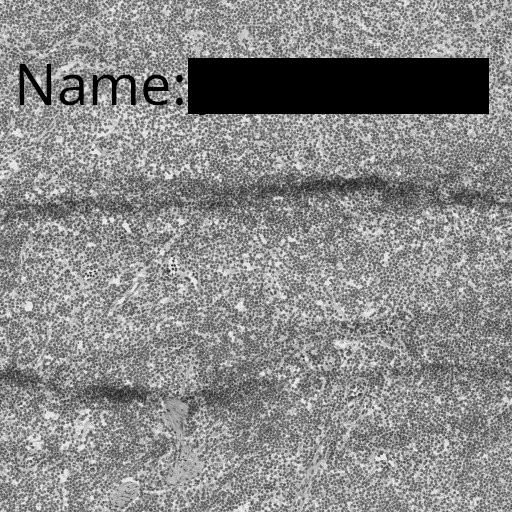


    Image #1:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/deid-and-obfuscation/tiles_output_157/Ocus40-sample-157/selected/Ocus40-sample-157_L3_T61.jpg
    Resolution: 0 dpi
    Width: 512 px
    Height: 512 px
    Mode: 10
    Number of channels: 1


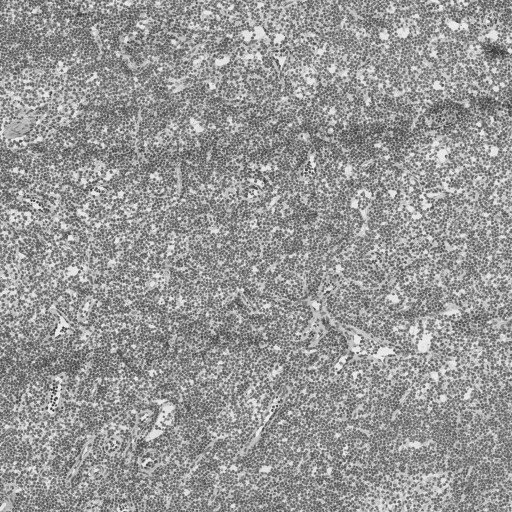

In [23]:
from sparkocr.utils import display_images
display_images(result_deid, "image_with_regions")

### Masking of specific tiles in the SVS
This is our final step!. We will mask the specific tiles in the source SVS using the regions we obtained during previous steps.</br>
First, let's create a copy of our files.

In [24]:
!cp -r "$output_path" deid_svs_copy

IOStream.flush timed out


In [27]:
from sparkocr.utils.svs.phi_redaction import redact_phi_in_tiles

redact_phi_in_tiles(svs_path="deid_svs_copy/Ocus40-sample-157.svs",
                    tiles_deid=deid_info,
                    main_folder=OUTPUT_FOLDER,
                    output_svs_path="deid_svs_copy/Ocus40-sample-157_deid.svs",
                    create_new_svs_file = True)

25/10/13 20:23:18 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/10/13 20:23:22 WARN PositionFinder: Empty or null entity value is not allowed.
25/10/13 20:23:22 ERROR ImageDrawRegions: Invalid or empty `coordinates`: Ensure it is non-empty and contains valid data.
25/10/13 20:23:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/10/13 20:23:26 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
20:23:29, INFO Starting deidentification on SVS: deid_svs_copy/Ocus40-sample-157.svs
20:23:29, INFO Total pages in SVS: 5


Thumbnail found at page 1: aperio image
thumbnail 896x896|mpp=0.250552|appmag
